In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet


In [7]:
data = pd.read_csv('merge.csv',encoding='gbk')

def select(data, title):
    data_new = data.rename(columns={"week_start_date": "ds", title: "y"})
    data_new['ds'] = pd.to_datetime(data_new['ds'])
    return data_new

data_sj = select(data[data['city'] == 'sj'], 'total_cases')
data_iq = select(data[data['city'] == 'iq'], 'total_cases')


In [8]:
def train_test_split(data):
    split_point = int(0.8 * len(data))
    train_data = data[:split_point]
    test_data =  data[split_point:]
    return train_data,test_data

train_sj, test_sj = train_test_split(data_sj)
train_iq, test_iq = train_test_split(data_iq)


12:20:12 - cmdstanpy - INFO - Chain [1] start processing
12:20:12 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing


San Juan MAE: 18.906939183001292
San Juan MAPE: 58.29377757887252
Iquitos MAE: 13.60819426548877
Iquitos MAPE: 100.0


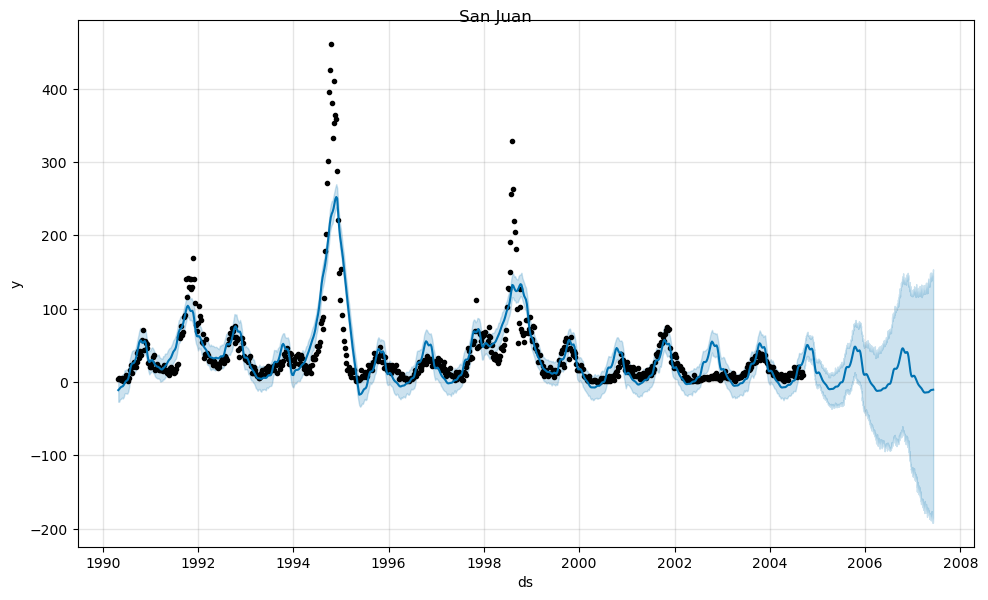

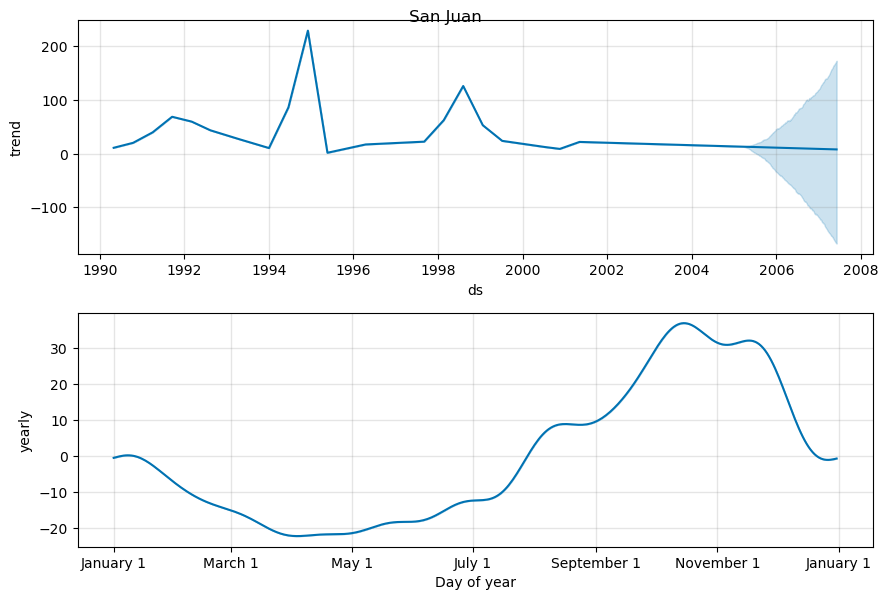

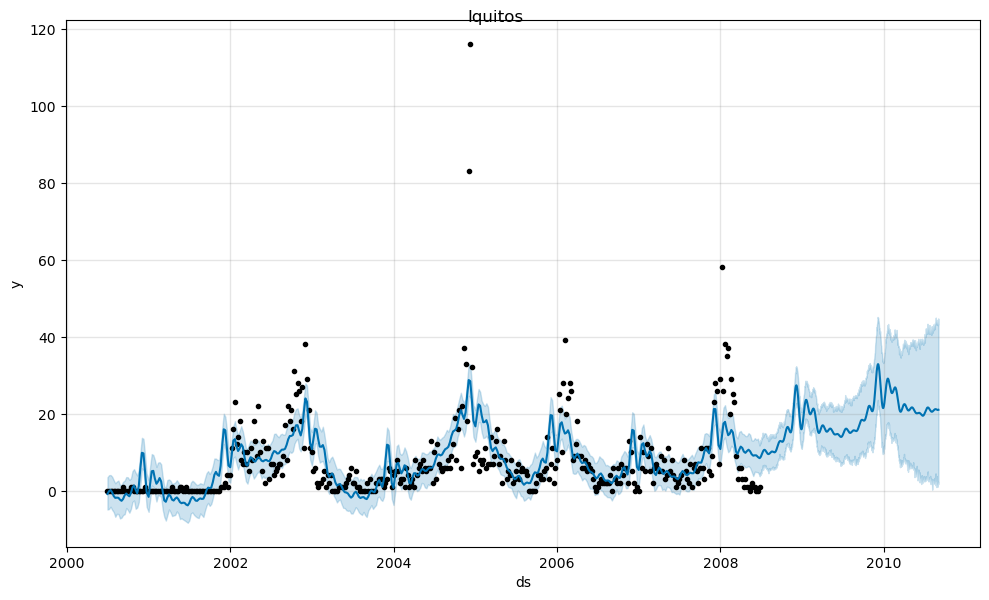

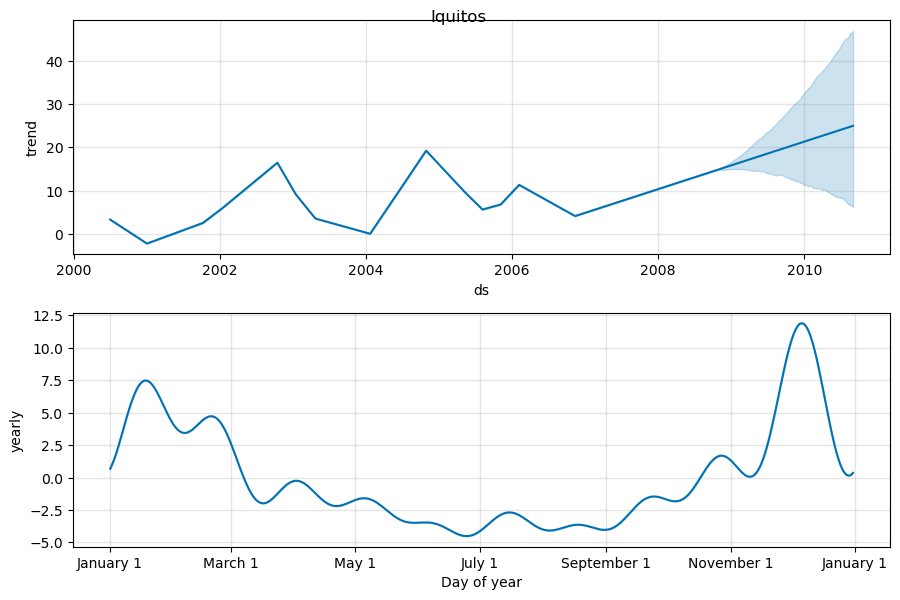

In [10]:
#初步建立模型
def model(train):
    pm=Prophet(changepoint_prior_scale=0.8,interval_width=0.4)
    # changepoint_prior_scale：增长趋势模型的灵活度，值越大，历史数据的拟合程度越强
    #interval_width：衡量未来时间内趋势改变的程度。值越大，趋势间隔出现的频率和幅度与历史数据越相似，
    pm.fit(train)
    return pm

#预测
def predict(pm,periods):
    future = pm.make_future_dataframe(periods)
    pm_forecast = pm.predict(future)
    return pm_forecast


def MAPE(data_true, data_pre):#平均百分比误差率评估
    data_true, data_pre = np.array(data_true), np.array(data_pre)
    return np.mean(np.abs((data_true - data_pre) / data_true))*100


#mean_absolute_error(y_test,y_pre)

#主函数
def work(train,test,title,periods):
    pm = model(train)
    predictions_data = predict(pm,periods)
    predictions_data["y"] = train["y"].reset_index(drop = True)
    results_data = predictions_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test[["ds","y"]])
    fig1 = pm.plot(predictions_data)
    fig1.suptitle(title,verticalalignment='center')
    fig2 = pm.plot_components(predictions_data)
    fig2.suptitle(title,verticalalignment='center')
    mae = mean_absolute_error(results_data['y'], results_data['yhat'])
    print(title + ' MAE: ' + str(mae))
    print(title+' MAPE: '+str(MAPE(results_data['yhat'].iloc[0], results_data['y'].iloc[0])))
    return results_data,predictions_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

results_sj = work(train_sj, test_sj,"San Juan",1000)

results_iq = work(train_iq, test_iq,"Iquitos",800)




